# SELF-SUPERVISED DENOISING: PART ONE
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

On completion of this tutorial you will have learnt how to write your own blind-spot denoising procedure that is trained in a self-supervised manner, i.e., the training data is the same as the inference data with no labels required!

### Methodology Recap
We will implement the Noise2Void 

***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Our unet functions just to speed things up
from unet_tracewise import UNet,init_net
from tutorial_utils_tracewise import  add_trace_wise_noise

In [2]:
cmap='seismic'
vmin = -1
vmax = 1

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the data folder of the repository: https://github.com/swag-kaust/Transform2022_SelfSupervisedDenoising

In [3]:
d = np.load("./augmentedagc_Hess_waveforms4Sixiu.npy")
print(d.shape)

(404, 512, 256)


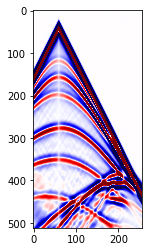

In [4]:
# Plot to see the noise free data
plt.imshow(d[80], cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

In [5]:
noisy_patches = add_trace_wise_noise(d, trace_num=10,trace_value=0.5)

(4040, 512, 256)


### Patch data

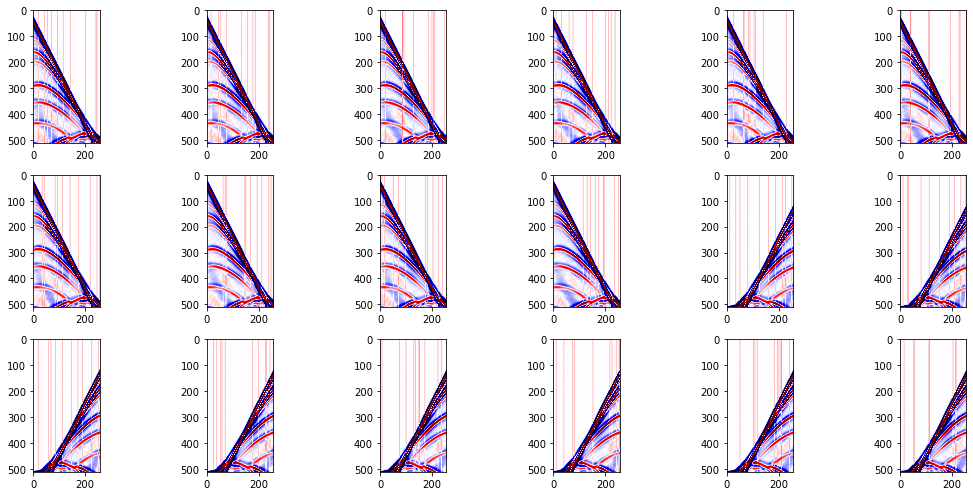

In [6]:
# plot to see the noisy data
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

# Step Two - Blindspot corruption of training data

In [7]:
# Create a function that randomly selects pixels and corrupts traces following StrucN2V methodology
def multi_active_pixels(patch, 
                        active_number,NoiseLevel,Maskwidth,metrice):

    # Select multiple locations for active pixels
    corr=[]                     
    for i in range( active_number*2):
        corr.append(np.random.randint(0,256,1))
    corr=np.array(corr).reshape([active_number,2])    
    
    
    # Make mask and Select metrice for calculating loss
    mask = np.ones_like(patch)
    if metrice=='active':
            mask[tuple(corr.T)] = 0
    
    elif metrice=='trace':
            mask[:,tuple(corr.T)[1]] = 0
     
    
    # Make corrupted patch
    cp_ptch=patch.copy()    
    mix=corr
    for i in range(Maskwidth+1):
        mixcopy=mix.copy()
        mixcopy.T[1]=mix.T[1]-i
        mixcopy = mixcopy.clip(min=np.zeros(2),max=np.array(patch.shape)-1).astype(np.uint)
        cp_ptch[:,tuple( mixcopy.T)[1]] = np.random.rand(patch.shape[0],corr.shape[0])*NoiseLevel*2 - NoiseLevel
       
    for i in range(Maskwidth):
        mixcopy=mix.copy()
        mixcopy.T[1]=mix.T[1]+i+1
        mixcopy = mixcopy.clip(min=np.zeros(2),max=np.array(patch.shape)-1).astype(np.uint)
        cp_ptch[:,tuple( mixcopy.T)[1]] = np.random.rand(patch.shape[0],corr.shape[0])*NoiseLevel*2 - NoiseLevel
        
    return cp_ptch, mask

In [8]:
# Check the corruption function works
crpt_patch, mask = multi_active_pixels(noisy_patches[0], 
                                  active_number=3, 
                                  NoiseLevel=0.5,Maskwidth=0,metrice='trace')

Text(0.5, 1.0, 'Corruption Mask')

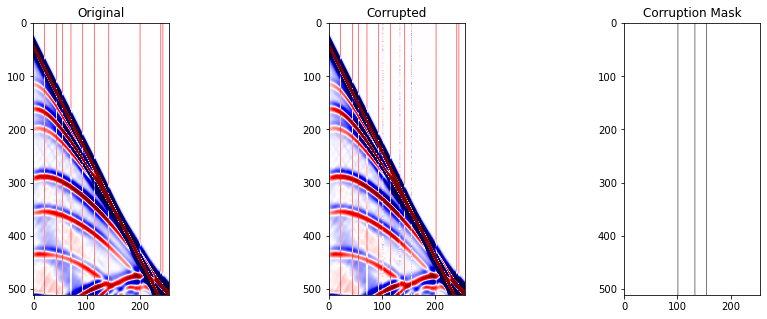

In [9]:
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(noisy_patches[0], cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(crpt_patch, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(mask, cmap='binary_r')

axs[0].set_title('Original')
axs[1].set_title('Corrupted')
axs[2].set_title('Corruption Mask')

***

# Step three - Set up network

In [10]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


In [11]:
# Build UNet
network = UNet(1, 1, 32, 'bnorm').to(device)
print(network)
init_net(network, init_type='normal', init_gain=0.02, gpu_ids=0)

UNet(
  (enc1_1): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(
        (relu): ReLU(inplace=True)
      )
    )
  )
  (enc1_2): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(
        (relu): ReLU(inplace=True)
      )
    )
  )
  (pool1): Pooling2d(
    (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (enc2_1): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm)

UNet(
  (enc1_1): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(
        (relu): ReLU(inplace=True)
      )
    )
  )
  (enc1_2): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(
        (relu): ReLU(inplace=True)
      )
    )
  )
  (pool1): Pooling2d(
    (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (enc2_1): CNR2d(
    (cbr): Sequential(
      (0): Conv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Norm2d(
        (norm)

In [14]:
# Network initialisation steps
n_epochs = 100
lr = 4*1e-3
criterion = nn.L1Loss()
optim = torch.optim.Adam(network.parameters(), betas=(0.5, 0.999),lr=lr)

In [15]:
# Data training parameters
n_training = 3200

***

# Step four - training

In [16]:
# Initial train and val 
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
val_loss_history = np.zeros(n_epochs)
val_accuracy_history = np.zeros(n_epochs)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

In [17]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    
    model.train()
    accuracy = 0
    loss = 0

    for dl in tqdm(data_loader):
        X, y, mask = dl[0], dl[1], dl[2]
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()
        yprob = model(X)

        # TO DO: Compute loss function only at masked locations
        # (Hint: only one line required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        
        ls.backward()
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        loss += ls.item()
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))
        
    loss /= len(data_loader)
    accuracy /= len(data_loader)   

    return loss, accuracy

In [18]:
torch.backends.cudnn.enabled=False

In [19]:
# TRAINING
for ep in range(n_epochs):  
    
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                  active_number=3, 
                                  NoiseLevel=0.5,Maskwidth=0,metrice='trace')

    # MAKE DATA LOADERS
    # Remember to add 1 to 2nd dim - Pytorch is [#data, #channels, height, width]
    # Define Train Set
    train_X = np.expand_dims(corrupted_patches[:n_training],axis=1)
    train_y = np.expand_dims(noisy_patches[:n_training],axis=1)    
    msk = np.expand_dims(masks[:n_training],axis=1)    
    
    X_train = torch.from_numpy(train_X).float()
    y_train = torch.from_numpy(train_y).float()
    train_dataset = TensorDataset(X_train, 
                                  y_train, 
                                  torch.from_numpy(msk).float(),)

    # Define Test Set
    test_X = np.expand_dims(corrupted_patches[n_training:],axis=1)
    test_y = np.expand_dims(noisy_patches[n_training:],axis=1)
    msk = np.expand_dims(masks[n_training:],axis=1) 
    X_test = torch.from_numpy(test_X).float()
    y_test = torch.from_numpy(test_y).float()
    test_dataset = TensorDataset(X_test, 
                                 y_test, 
                                 torch.from_numpy(msk).float(),)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    # TRAIN
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)

#     test_loss, test_accuracy, test_metrics = n2v_evaluate(network, 
#                                                            criterion,
#                                                            test_loader, 
#                                                            device,
#                                                             synth=False,
#                                                             plotflag=True if ep%5==0 else False)

    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy
#     test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy
    
    basedir = os.path.join("./newnet")
    if not os.path.exists(basedir):
        os.makedirs(basedir)
    
    if ep%1==0: 
        mod_name ='denoise_ep%i.net'%ep
        torch.save(network, basedir+'/'+mod_name)
    

    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, ''')
#     Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')
    
    
    
    



 68%|██████▊   | 547/800 [00:53<00:24, 10.21it/s]


KeyboardInterrupt: 

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(train_accuracy_history, 'r', lw=2, label='train')
# axs[0].plot(test_accuracy_history, 'k', lw=2, label='validation')
axs[0].set_title('RMSE', size=16)
axs[0].set_ylabel('RMSE', size=12)

axs[1].plot(train_loss_history, 'r', lw=2, label='train')
# axs[1].plot(test_loss_history, 'k', lw=2, label='validation')
axs[1].set_title('Loss', size=16)
axs[1].set_ylabel('Loss', size=12)


for ax in axs:
    ax.legend()
    ax.set_xlabel('# Epochs', size=12)
fig.tight_layout()

***

## Step five - apply trained model

In [ ]:
d.shape

In [ ]:
# Make a new noisy realisation so it's different from the training set
testdata = add_trace_wise_noise(d, trace_num=10,trace_value=0.5)[800]

In [ ]:
for ep in range(100):
    
    netG = UNet(1, 1, 32, 'bnorm').to(device)
    init_net(netG, init_type='normal', init_gain=0.02, gpu_ids=0)
    netG=torch.load('./TESTnet/denoise_ep'+str(ep)+'.net')
    
    torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()
    test_prediction = netG(torch_testdata.to(device))
    test_pred = test_prediction.detach().cpu().numpy().squeeze()
    
    fig,axs = plt.subplots(1,4,figsize=[15,4])
    axs[0].imshow(d[80], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].imshow(testdata, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[2].imshow(test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[3].imshow(testdata-test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    axs[0].set_title('Clean'+str(ep))
    axs[1].set_title('Noisy')
    axs[2].set_title('Denoised')
    axs[3].set_title('Noise Removed')

    fig.tight_layout()